## Navier Stokes Equation

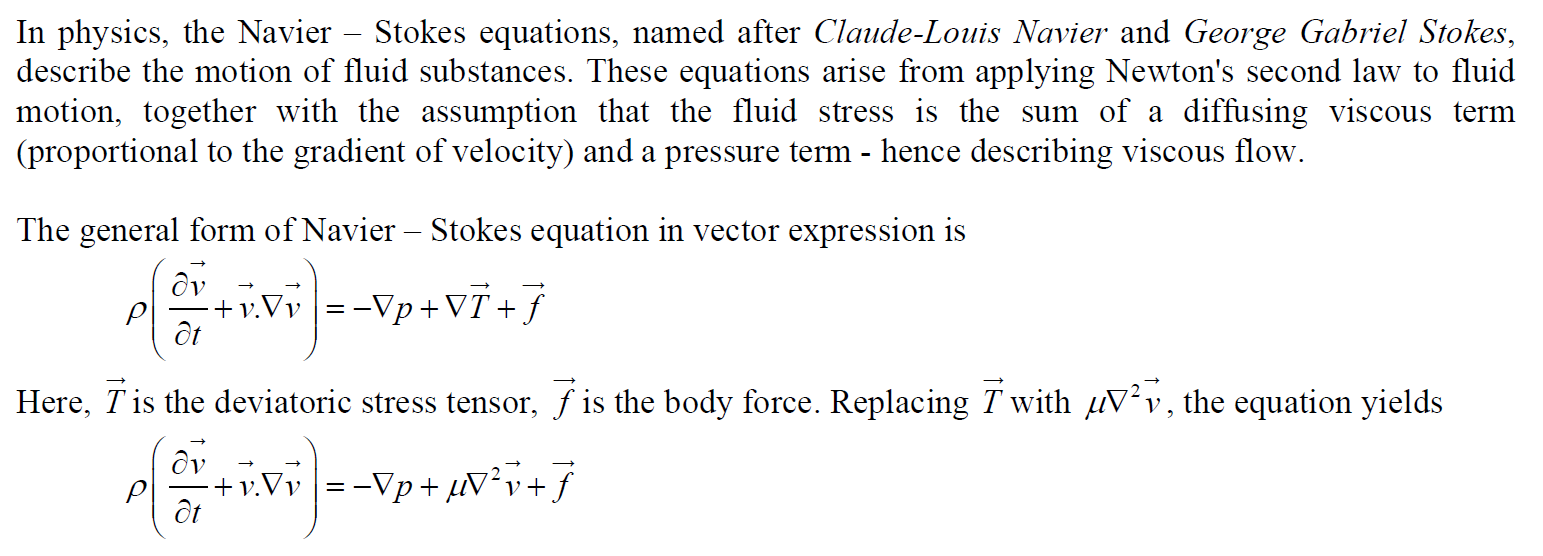

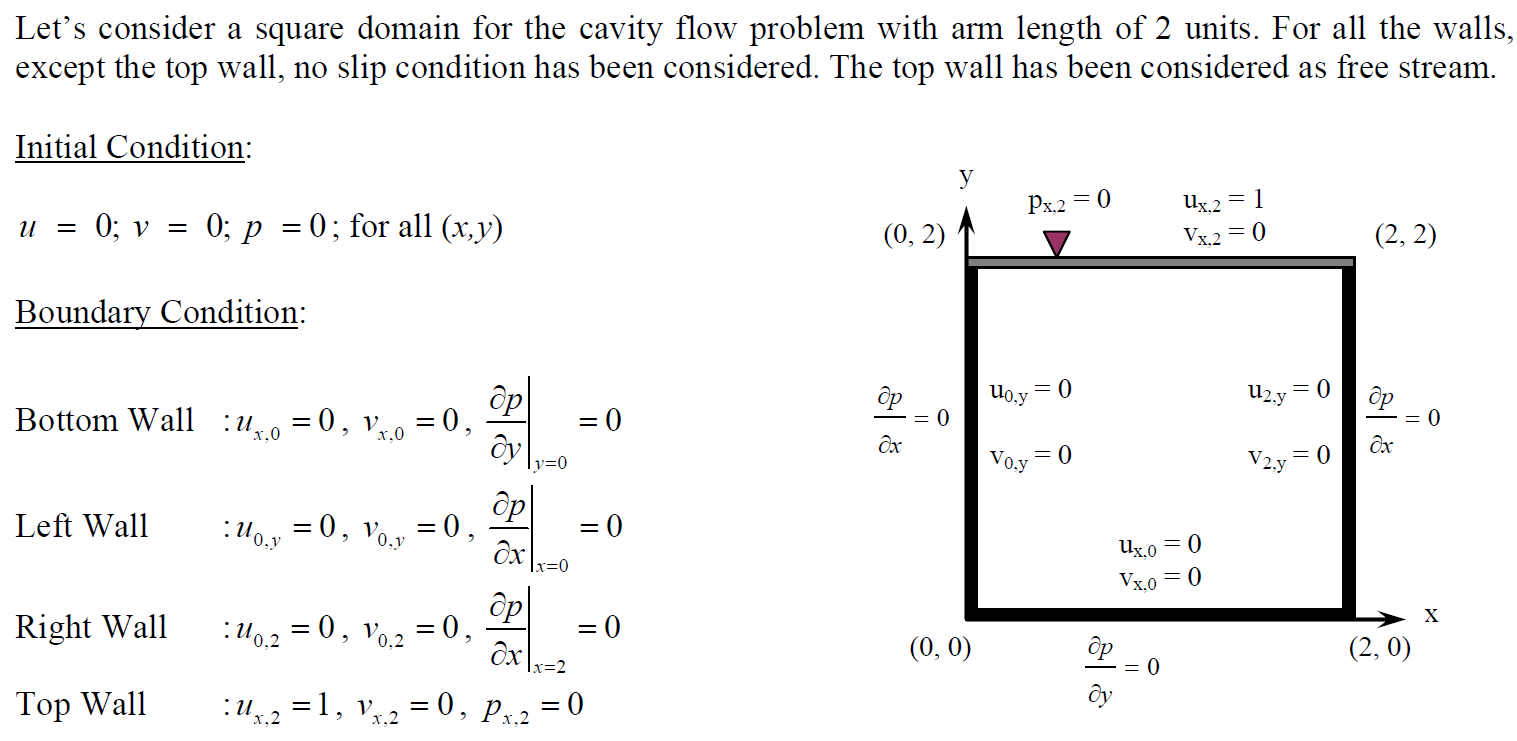

### Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

### Initial Conditions and Variables

In [2]:
nx  = 21                           # Number of nodes in the x-direction 
ny  = 21                           # Number of nodes in the y-direction 

nt  = 500                          # Number of time steps
nit = 10                           # Number of artificial time steps

vis = 0.1                          # Viscosity
rho = 1.0                          # Density
Lx  = 2                            # Length in the x-direction
Ly  = 2                            # Length in the y-direction

dx  = Lx/(nx-1)                    # Grid spacing in the x-direction 
dy  = Ly/(ny-1)                    # Grid spacing in the y-direction

dt  = 0.01                        # time-step size

x   = np.arange(0,Lx+dx,dx)        # Node x-ordinates
y   = np.arange(0,Ly+dy,dy)        # Node y-ordinates

u   = np.zeros((ny,nx))            # Nodal velocity x-component
v   = np.zeros((ny,nx))            # Nodal velocoty y-component

p   = np.zeros((ny,nx))            # Nodal pressure
un   = np.zeros((ny,nx))           # Time marched velocity x-direction
vn   = np.zeros((ny,nx))           # Time marched velocity y-direction

pn   = np.zeros((ny,nx))           # Temporary pressure for calculations
b    = np.zeros((ny,nx))           # Nodal source term value from pressure


### Function to calculate the Nodal source terms from the pressure
We have used the NumPy arrays to optimize the calculations and elimated the loops

In [33]:
def build_up_b(b,u,v):
    
     # Below procedure is optimized python code, or in short I used array operations to avoid any kind of loop hustles which may take years to compile :p

    b[1:-1, 1:-1] = -((1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) +
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

### Utility functions to calculate the Pressure from the Poisson 

In [39]:
def pressure_poisson1(u,v,p,b):

    pn = np.empty_like(p)
    pn = p.copy()
    # pn has all boundary related elemnts after 1st time loop
    # Below loop helps us to achieve pressure terms from boundary to whole surface via differential schemes in time.
    # Indeed we used boundary conditions and  get the whole surface discretely

    for q in range(nit):

        # (n-1)th time presssure part is used to calculate nth time pressure.
        pn = p.copy()

        # optimized python code for our PP equation  
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) +
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
    
      # boundary conditions 
      # utilized backward difference scheme and equated it to 0 
      
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2  
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = p[-2,:]        # p = 0 at y = 2
        
    return p

def build_p(u,v,pn):
    
    #dz2y2 = (dz*dy)**2
    dx2 = (dx)**2
    dy2 = (dy)**2
    #dz2x2 = (dz*dx)**2
    dx_div = (dx2+dy2)
    
    uu = ((u[1:-1,2:]-u[1:-1,:-2])/dx)**2 + ((v[2:,1:-1]-v[:-2,1:-1])/dy)**2# + ((w[2:,1:-1,1:-1]-w[:-2,1:-1,1:-1])/dz)**2
    uv = 2*((u[2:,1:-1]-u[:-2,1:-1])/dy)*((v[2:,1:-1]-v[:-2,1:-1])/dx)
    #vw = 2*((v[2:,1:-1,1:-1]-v[:-2,1:-1,1:-1])/dz)*((w[1:-1,2:,1:-1]-w[1:-1,:-2,1:-1])/dy)
    #wu = 2*((w[1:-1,1:-1,2:]-w[1:-1,1:-1,:-2])/dx)*((u[2:,1:-1,1:-1]-u[:-2,1:-1,1:-1])/dz)
    
    pterms = 0.5*((pn[1:-1,2:]+pn[1:-1,:-2])*(dy2)+(pn[2:,1:-1]+pn[:-2,1:-1])*(dx2))/(dx_div)
    tterms = 0.25*rho*((dx*dy)**2)*((u[1:-1,2:]-u[1:-1,:-2])/dx+(v[2:,1:-1]-v[:-2,1:-1])/dy)/(dx_div*dt)
    uterms = 0.125*rho*((dx*dy)**2)*(uu+uv)/(dx_div)

    p = pterms+tterms+uterms
    return p

## Poisson Equation to calculate the pressure

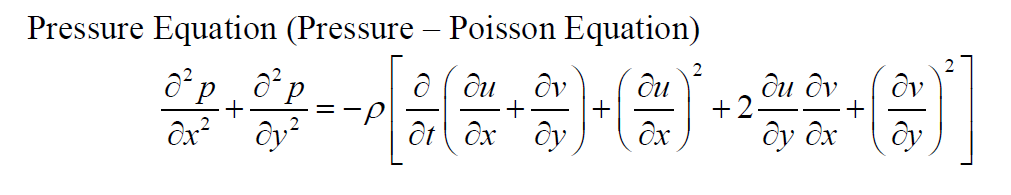

In [40]:
def pressure_poisson(u,v,p):
    #print("Pressure Poisson",pn.shape)
    #pn = np.copy(p)
    for q in range(nit):
        pn = np.copy(p)
        p[1:-1,1:-1] = build_p(u,v,pn)
        #Apply BCs
        p[-1,:] = 0
        p[:,-1] = p[:,-2]
        p[:,0]  = p[:,1]
        p[0,:]  = p[1,:]
        #p[0,:,:]  = p[1,:,:]
        #p[-1,:,:] = p[-2,:,:]
        
    return p


### Function to calculate the Profile in the cavity

In [41]:
def cavity_flow(nt,u,v,p,b,vis):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    #wn = np.empty_like(w)

    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        #wn = w.copy()

        #Calculating Pressure
        
        #print(n)
        b = build_up_b(b, u, v)
        p = pressure_poisson1(un,vn,p,b)
        #print(p.shape)
        #Calculating U velocity using NS
        
        pu = -1*(0.5*dt)*(p[1:-1,2:]-p[1:-1,:-2])/(rho*dx)
        pv = -1*(0.5*dt)*(p[2:,1:-1]-p[:-2,1:-1])/(rho*dy)
        #pw = -1*(0.5*dt)*(p[2:,1:-1,1:-1]-p[:-2,1:-1,1:-1])/(rho*dz)
        
        uij =  un[1:-1,1:-1]
        vij =  vn[1:-1,1:-1]
        #wij =  wn[1:-1,1:-1,1:-1]

        ui1j = un[1:-1,2:]
        vi1j = vn[1:-1,2:]
        #wi1j = wn[1:-1,2:]

        uin1j = un[1:-1,:-2]
        vin1j = vn[1:-1,:-2]
        #win1j = wn[1:-1,:-2]

        uij1 = un[2:,1:-1]
        vij1 = vn[2:,1:-1]
        #wij1 = wn[1:-1,2:,1:-1]

        uijn1 = un[:-2,1:-1]
        vijn1 = vn[:-2,1:-1]
        #wijn1 = wn[:-2,1:-1]

        #uik1 = un[2:,1:-1,1:-1]
        #vik1 = vn[2:,1:-1,1:-1]
        #wik1 = wn[2:,1:-1,1:-1]

        #uikn1 = un[:-2,1:-1,1:-1]
        #vikn1 = vn[:-2,1:-1,1:-1]
        #wikn1 = wn[:-2,1:-1,1:-1]

        velu = -1*dt*(uij*(uij-uin1j)/dx + vij*(uij-uijn1)/dy )#+ wij*(uij-uikn1)/dz)
        velv = -1*dt*(uij*(vij-vin1j)/dx + vij*(vij-vijn1)/dy )# + wij*(vij-vikn1)/dz)
        #velw = -1*dt*(uij*(wij-win1j)/dx + vij*(wij-wijn1)/dy + wij*(wij-wikn1)/dz)

        visu = vis*dt*((ui1j+uin1j-2*uij)/(dx*dx) + (uij1+uijn1-2*uij)/(dy*dy))# + (uik1+uikn1-2*uij)/(dz*dz))
        visv = vis*dt*((vi1j+vin1j-2*vij)/(dx*dx) + (vij1+vijn1-2*vij)/(dy*dy))# + (vik1+vikn1-2*vij)/(dz*dz))
        #visw = vis*dt*((wi1j+win1j-2*wij)/(dx*dx) + (wij1+wijn1-2*wij)/(dy*dy) + (wik1+wikn1-2*wij)/(dz*dz))

        #velu = -1*(un[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[:-2,1:-1,1:-1])*(dt/dz))
        #velv = -1*(un[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[:-2,1:-1,1:-1])*(dt/dz))
        #velw = -1*(un[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[:-2,1:-1,1:-1])*(dt/dz))
        
        #visu = (vis)*dt*((un[1:-1,1:-1,2:]+un[1:-1,1:-1,:-2]-2*un[1:-1,1:-1,1:-1])/(dx*dx)+(un[1:-1,2:,1:-1]+un[1:-1,:-2,1:-1]-2*un[1:-1,1:-1,1:-1])/(dy*dy)+(un[2:,1:-1,1:-1]+un[:-2,1:-1,1:-1]-2*un[1:-1,1:-1,1:-1])/(dz*dz))
        #visv = (vis)*dt*((vn[1:-1,1:-1,2:]+vn[1:-1,1:-1,:-2]-2*vn[1:-1,1:-1,1:-1])/(dx*dx)+(vn[1:-1,2:,1:-1]+vn[1:-1,:-2,1:-1]-2*vn[1:-1,1:-1,1:-1])/(dy*dy)+(vn[2:,1:-1,1:-1]+vn[:-2,1:-1,1:-1]-2*vn[1:-1,1:-1,1:-1])/(dz*dz))
        #visw = (vis)*dt*((wn[1:-1,1:-1,2:]+wn[1:-1,1:-1,:-2]-2*wn[1:-1,1:-1,1:-1])/(dx*dx)+(wn[1:-1,2:,1:-1]+wn[1:-1,:-2,1:-1]-2*wn[1:-1,1:-1,1:-1])/(dy*dy)+(wn[2:,1:-1,1:-1]+wn[:-2,1:-1,1:-1]-2*wn[1:-1,1:-1,1:-1])/(dz*dz))
        
        #print(velu.shape)
        #print(pu.shape)
        #print(visu.shape)
        u[1:-1,1:-1] = un[1:-1,1:-1]+velu+pu+visu
        v[1:-1,1:-1] = vn[1:-1,1:-1]+velv+pv+visv
        #w[1:-1,1:-1,1:-1] = wn[1:-1,1:-1,1:-1]+velw+pw+visw

        #v[0,:,: ]  = 0
        #v[-1,:,:]  = 0
        v[0,: ]  = 0
        v[-1,:]  = 0
        v[:,0 ]  = 0
        v[:,-1]  = 0

        #w[0,:,: ]  = 0
        #w[-1,:,:]  = 0
        #w[:,0,: ]  = 0
        #w[:,-1,:]  = 0
        #w[:,:,0 ]  = 0
        #w[:,:,-1]  = 0

        
        #u[0,:,: ]  = 0
        #u[-1,:,:]  = 0
        u[:, 0]  = 0
        u[:,-1]  = 0
        u[0,: ]  = 0
        u[-1,:]  = 1

    return u,v,p 



### Running the above functions 

In [42]:
if __name__ == '__main__':
    u   = np.zeros((ny,nx))
    v   = np.zeros((ny,nx))
    p   = np.zeros((ny,nx))
    b    = np.zeros((ny,nx))
    #Boundary Conditions
    x   = np.arange(0,Lx+dx,dx)
    y   = np.arange(0,Ly+dy,dy)
    x,y = np.meshgrid(x,y)


  
    u[:, 0]  = 0.0
    u[:,-1]  = 0.0
    u[0,: ]  = 0.0
    u[-1,:]  = 1.0
    
    nt = 1000
    u,v,p = cavity_flow(nt,u,v,p,b,vis)

### Plotting the Cavity for the better visualization

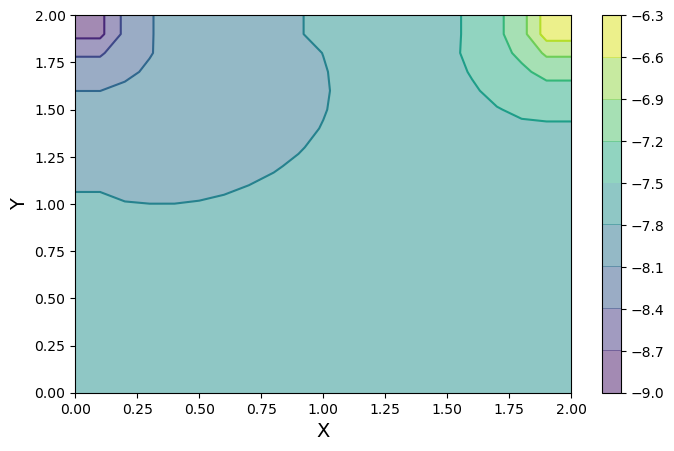

In [43]:
fig = plt.figure(figsize=(8,5),dpi=100)
plt.contourf(x,y,p[:,:],alpha=0.5,cmap=cm.viridis)
plt.colorbar()
plt.contour(x,y,p[:,:],cmap=cm.viridis)
#plt.quiver(x[::3,::3],y[::3,::3],u[::3,::3],v[::3,::3])
plt.xlabel('X', fontsize = 14)
plt.ylabel('Y', fontsize = 14)
plt.show()

### Surface Plot for the x-component of the velocity

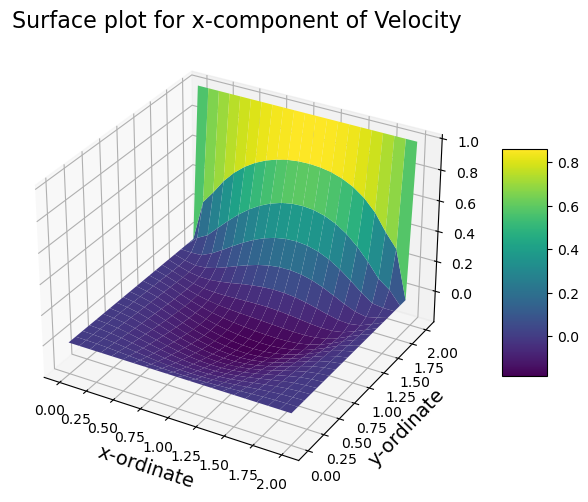

In [44]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, u,cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot for x-component of Velocity', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

### Surface Plot for the y-component of the velocity

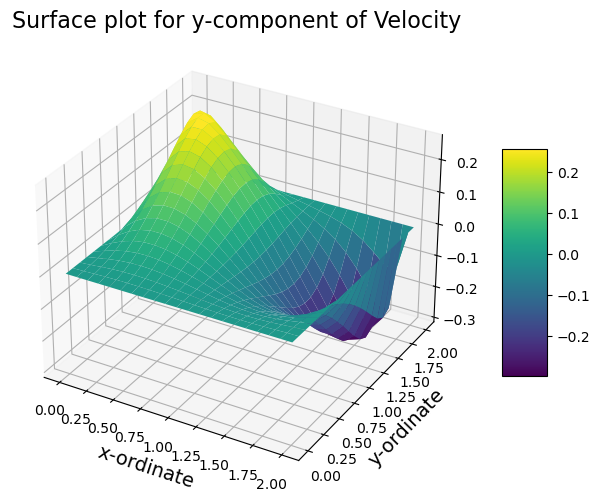

In [45]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface( x, y, v,cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot for y-component of Velocity', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

### Surface Plot of the Velocity Field U

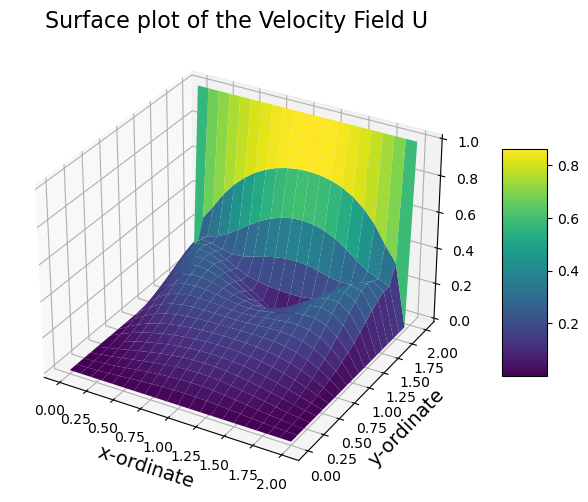

In [46]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, np.sqrt(np.power(u,2)+np.power(v,2)),cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot of the Velocity Field U', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

### Surface Plot of the Pressure P

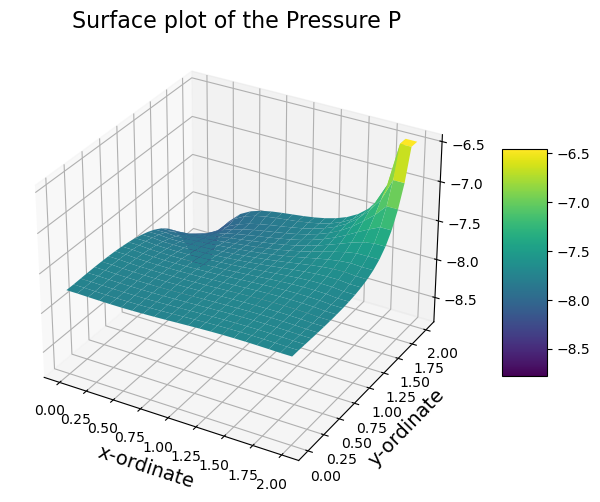

In [47]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, p,cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot of the Pressure P', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

In [48]:
print(u[:,:])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -6.22002386e-04 -2.22789607e-03 -5.57877095e-03
  -9.97483335e-03 -1.48991017e-02 -1.97872595e-02 -2.41585239e-02
  -2.76161101e-02 -2.98601377e-02 -3.06929951e-02 -3.00284928e-02
  -2.79029448e-02 -2.44854439e-02 -2.00816700e-02 -1.51266217e-02
  -1.01538724e-02 -5.76043097e-03 -2.45159231e-03 -7.80442682e-04
   0.00000000e+00]
 [ 0.00000000e+00 -1.99461017e-03 -5.68931030e-03 -1.20764203e-02
  -2.00258078e-02 -2.87166102e-02 -3.72439711e-02 -4.48212738e-02
  -5.07905723e-02 -5.46513513e-02 -5.60746003e-02 -5.49194900e-02
  -5.12504243e-02 -4.53509020e-02 -3.77259080e-02 -2.90859726e-02
  -2.02943721e-02 -1.23097873e-02 -5.9